<a href="https://colab.research.google.com/github/cyankaet/orderml/blob/master/orderparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount drive only when ls test fails


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/orderml

/content/drive/My Drive/orderml


Any other drive folder is, hint, probably not the correct one! Navigate to where your orderml folder is in your drive. This code should work for a top-level folder.

Check you're in the right folder. ("ls test")


In [3]:
ls

logs/  orderparams.ipynb  problems.txt  __pycache__/  test.png


Install non-default packages here.

In [4]:
!pip install bumps
!pip install gym

     |████████████████████████████████| 522kB 2.6MB/s 
  Created wheel for bumps: filename=bumps-0.7.16-cp36-none-any.whl size=546174 sha256=7d970a21ced01b8690564281f50a0a72dd910402d4c4e9fea4c20ec2e8a91006
  Stored in directory: /root/.cache/pip/wheels/41/f7/17/a898c85754ad1c6d7de087e28809af7989b81f14f200547de3
Successfully built bumps


"Compile" code.

Execute main class.

In [ ]:
import sys
import numpy as N
import pylab as plt
import scipy.optimize as optimize
from bumps.names import *
import bumps.fitters as fitters
import gym.spaces as spaces

class OrderEnv(gym.Env): #add gym.env

    def __init__(self):
        self.reward_scale = 100
        self.episodeNum = 0
        self.steps = 0
        self.T = []
        self.startTn = 160
        self.p = [.885,330,.3]
        # self.M = Curve(orderparameter, T, I, error, Jt = self.p[0], Nf = self.p[1], Bk = self.p[2])
        # self.M.Tn.range(self.startTn - 20 , self.startTn + 20)

        self.observation_space = spaces.Box(3, 340)
        #self.action_space = spaces.Box(0, 337)
        self.curTemp = 3
        self.x = self.startTn

        #logging arrays and vars
        self.rewards = [] #interepisodic
        self.chisqds = []
        self.transTemps = []
        self.totReward = 0      

    def step(self, action): 

        self.curTemp += action
        self.curTemp = round_to(self.curTemp, 0.5)

        self.steps += 1
        reward = -self.reward_scale

        if self.steps > 1:
            self.T.append(self.curTemp)
            self.I = getData(self.T, self.x)
            self.M = Curve(orderparameter, T, self.I, error, Jt = self.p[0], Nf = self.p[1], Bk = self.p[2])
            self.M.Tn.range(self.x - 20 , self.x + 20)

            self.x, dx, chisq, params = fit(self.M)

            dx = params[0].dx

            if chisq < 10:
                reward += 1000

                if dz < 2e-3:
                    reward+=1/dz

            self.chisqds.append(chisq)
            self.transTemps.append(self.x)

        self.totReward += reward

        if (self.steps > 10 and chisq < 0.05):
            terminal = True
            self.log()
        if (self.steps > 30):
            terminal = True
            self.log()
        else:
            terminal = False

        return self.state, reward, terminal #missing state


    def reset(self):
        self.steps = 0
        self.T = []
        self.I = []
        self.chisqds = []
        self.transTemps = []
        self.totReward = 0
        self.curTemp = 3

        return self.state #starting state


    def fit(model):
        problem = FitProblem(model)
        result = fitters.fit(problem, method='lm')
        for p, v in zip(problem._parameters, result.dx):
            p.dx = v
        return result.x, result.dx, problem.chisq(), problem._parameters


    def log(self): #not required but for us
        self.episodeNum += 1

        filename = "logs/chis/chiLog-" + str(self.episodeNum) + ".txt"
        np.savetxt(filename, self.chisds)

        filename = "logs/temps/tnLog-" + str(self.episodeNum) + ".txt"
        np.savetxt(filename, self.transTemps)

        self.rewards.append(self.totReward)
        filename = "logs/runrewards.txt"
        np.savetxt(filename, self.rewards)

    @property
    def action_space(self):
        return spaces.Box(0, 340 - self.curTemp)

    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def getData(self, T, x, Jt = self.p[0], Nf = self.p[1], Bk = self.p[2]):
        return orderparameter(T, x, Jt, Nf, Bk)

    def bsol(temp,p):
        Tn,Jt,Nf,Bk=p
        t=4.0*(Jt/(Jt+1.0))*Tn/temp
        #print t
        if (Tn<=0) or (Jt<=0) or temp>=Tn:
            xout=0.0
        else:
            xout=optimize.brentq(bfun,0.0,t,args=(temp,p),xtol=1e-6)
    
        return xout
 
    def bfun(x,T,p):
        Tn,Jt,Nf,Bk=p
        if x==0.0:
            B=-1.0 # so that it wont find solution at zero
        else:
            B=(x-3*brill(Jt,x)*(Jt/(Jt+1))*(Tn/T))
        return B
    
    def brill(j,x):
        temp=(2*j+1.0)/2/j
        if x==0:
            Br=0.0
        else:
            Br=temp/N.tanh(temp*x)-1.0/N.tanh(x/2/j)/2/j
        return Br
    
    def Intensity(T,p):
        Tn,Jt,Nf,Bk=p
        br=brill(Jt,bsol(T,p))
        bout=Bk+Nf*br**2
        return bout

    def orderparameter(T, Tn, Jt, Nf, Bk):
        p=[Tn, Jt, Nf, Bk]
        I=[]
        for t in T:
            I.append(Intensity(t,p))
        return N.array(I)

    def fit(model):
        problem = FitProblem(model)
        result = fitters.fit(problem, method='lm')
        for p, v in zip(problem._parameters, result.dx):
            p.dx = v
        return result.x, result.dx, problem.chisq(), problem._parameters


NameError: ignored

[150.]


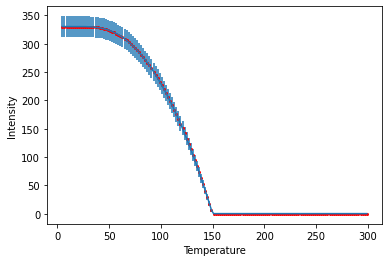

In [ ]:
if __name__=='__main__':
 
    #p=[50.0,0.5,100.0,0.0]
    p=[150,.885,330,.3 ]
    #p = [300, .786, 150, .9]
    T=N.arange(5,300.0,2)
    #T=N.arange(10,300,2)
    I=[]
    error = []

    I=orderparameter(T, p[0],p[1],p[2],p[3])
    error= N.sqrt(I)
    #print(error)
    
    M = Curve(orderparameter, T, I, error, Jt = p[1], Nf = p[2], Bk = p[3])
    M.Tn.range(10,400)

    x, dx, chisq, params = fit(M)
    print(x)

    fitI = orderparameter(T, x, p[1],p[2],p[3])

    plt.errorbar(T, I, error)
    plt.plot(T, fitI,'ro', markersize = 2)
    plt.xlabel("Temperature")
    plt.ylabel("Intensity") 
    plt.show()
    plt.savefig("test")
    plt.close()